### Estudio de caso analítico de una empresa de venta de entradas de eventos ###

El objetivo de este proyecto es identificar:
* cómo los clientes usan el servicio;
* cuándo empiezan a comprar;
* cuánto dinero aporta cada cliente a la compañía;
* cuándo los ingresos cubren el costo de adquisición de los clientes.

#### Análisis exploratorio de datos ####

In [1]:
# Carga las librerias 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from operator import attrgetter

In [2]:
# Carga los datasets
visits_df = pd.read_csv('/datasets/visits_log_us.csv')
orders_df = pd.read_csv('/datasets/orders_log_us.csv')
costs_df = pd.read_csv('/datasets/costs_us.csv')

In [3]:
# Explora la información de los datasets
print(visits_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


In [4]:
print(orders_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


In [5]:
print(costs_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


In [6]:
# Muestra el contenido de los datasets
display(visits_df.head(3))

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


In [7]:
display(orders_df.head(3))

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


In [8]:
display(costs_df.head(3))

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


In [9]:
# Visualiza valores duplicados
visits_df.duplicated().sum()

0

In [10]:
orders_df.duplicated().sum()

0

In [11]:
costs_df.duplicated().sum()

0

In [12]:
# Visualiza valores nulos
visits_df.isnull().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [13]:
orders_df.isnull().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [14]:
costs_df.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [15]:
# Cambia nombres de columnas a minúsculas y elimina espacios
visits_df.columns = visits_df.columns.str.strip().str.lower().str.replace(' ', '_')
orders_df.columns = orders_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [16]:
# Conviete fechas a datetime 
visits_df['start_ts'] = pd.to_datetime(visits_df['start_ts'])
visits_df['end_ts'] = pd.to_datetime(visits_df['end_ts'])
orders_df['buy_ts'] = pd.to_datetime(orders_df['buy_ts'])
costs_df['dt'] = pd.to_datetime(costs_df['dt'])

Los datos no presentan duplicados ni valores nulos, se estandariza el nombre de las columnas y los datos de fechas se convierten al tipo datetime. 

#### Informes y cálculo de métricas ####

#### Visitas ####

In [17]:
# Número de usuarios por día, semanal y mensual
# Agrega columnas de fecha(sin la hora), semana, mes y año al df
visits_metrics = visits_df.copy()
visits_metrics['session_week'] = visits_df['start_ts'].dt.isocalendar().week
visits_metrics['session_month'] = visits_df['start_ts'].dt.month
visits_metrics['session_year'] = visits_df['start_ts'].dt.isocalendar().year
visits_metrics['session_date'] = visits_df['start_ts'].dt.date

In [18]:
# Número de usuarios únicos por dia DAU
dau_total = visits_metrics.groupby('session_date').agg({'uid': 'nunique'}).mean().round()
print(dau_total)

uid    908.0
dtype: float64


In [19]:
# Usuarios únicos por semana WAU
wau_total = visits_metrics.groupby(['session_year', 'session_week']).agg(
    {'uid': 'nunique'}).mean().round()
print(wau_total)

uid    5716.0
dtype: float64


In [20]:
# Usuarios mensuales únicos MAU
mau_total = visits_metrics.groupby(['session_year', 'session_month']).agg(
    {'uid': 'nunique'}).mean().round()
print(mau_total)

uid    23228.0
dtype: float64


In [21]:
# Número de sesiones por día
sessions_per_day = visits_metrics.groupby('session_date').agg(
    {'uid': 'count'}).mean().round()
print(sessions_per_day)

uid    987.0
dtype: float64


In [22]:
# Calcula duración de cada sesión 
visits_metrics['session_duration_sec'] = (visits_df['end_ts'] 
                                          - visits_df['start_ts']).dt.seconds

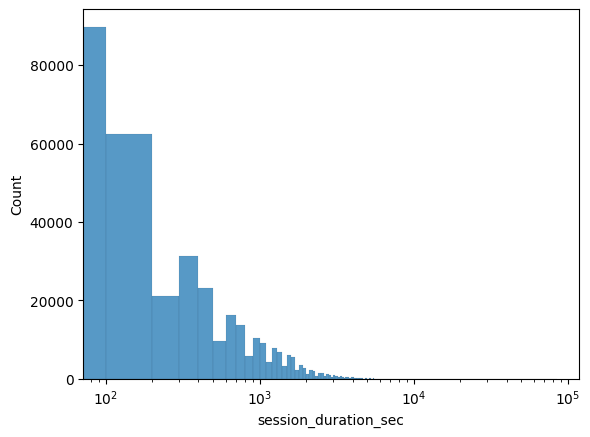

In [23]:
sns.histplot(data=visits_metrics, x='session_duration_sec', binwidth=100)
plt.xscale('log')

<div class="alert alert-block alert-info">
<b>Comentario estudiante</b><a class="tocSkip"></a>
La representación de los datos en escala logarítmica nos permite observar de manera más clara la distribución real de la duración de las sesiones en casos donde el rango es bastante amplio. La mayor concentración de sesiones se encuentra entre 0 y 100 segundos.
</div>

In [24]:
visits_metrics['session_duration_sec'].value_counts().head()

60     53029
0      35794
120    35748
180    26672
240    21085
Name: session_duration_sec, dtype: int64

In [25]:
# Calcula duración media de la sesión ASL
asl = visits_metrics['session_duration_sec'].mode()
print(asl)

0    60
dtype: int64


In [26]:
visits_metrics['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

El número de usuarios únicos por período de tiempo que visitan la plataforma son los siguientes:
* DAU, usuarios únicos por día: 908
* WAU, usuarios únicos por semana: 5716
* MAU, usuarios únicos por mes: 23228

En cuanto a las sesiones, se llevan a cabo 987 diariamente.  La distribución de la duración es muy asimétrica con valores extremos que van desde 0 a 84.400 segundos, el período que se presenta con mayor frecuencia es de 60 segundos.

In [27]:
# Frecuencia con la que los usuarios regresan
# Calcula el número de sesiones mensuales por usuario
sessions_per_user = visits_metrics.groupby(['session_year',
                                            'session_month']).agg(
    {'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] 
                                          / sessions_per_user['n_users'])
sessions_per_user

n_sessions  n_users  sessions_per_user
session_year session_month                                        
2017         6                   16505    13259           1.244815
             7                   17828    14183           1.256998
             8                   14355    11631           1.234202
             9                   23907    18975           1.259921
             10                  37903    29692           1.276539
             11                  43969    32797           1.340641
             12                  41983    31557           1.330386
2018         1                   36939    28716           1.286356
             2                   37182    28749           1.293332
             3                   35679    27473           1.298693
             4                   26515    21008           1.262138
             5                   26635    20701           1.286653

En promedio, cada usuario ingresa entre 1.24 y 1.34 sesiones por mes, se puede decir que solamente un porcentaje pequeño regresa por segunda vez el mismo mes.  El incremento en los valores de sesiones por usuario puede sugerir que hay mayor regularidad de las las visitas a la plataforma a partir de octubre de 2017. En noviembre y diciembre se observan los valores máximos, pero a pesar su descenso gradual en 2018, son más altos en comparación a los de los primeros meses del año anterior.

#### Ventas ####

In [28]:
# ¿Cuándo empieza la gente a comprar?

# Identifica la fecha de la primera visita de cada usuario
first_visits = visits_df.groupby('uid').agg({'start_ts': 'min'}).reset_index()
# Asigna nombres a las columnas
first_visits.columns = ['uid', 'first_visit_day']
# Agrega la fecha de la primera visita al df original
visits_ = pd.merge(visits_metrics, first_visits, on='uid')

In [29]:
# Identifica la fecha de la primera compra de cada usuario
first_orders_date = orders_df.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
# Asigna nombres a las columnas
first_orders_date.columns = ['uid', 'first_order_day']
# Agrega la fecha de la primera compra al df original
orders_metrics = orders_df.copy()
orders_ = pd.merge(orders_metrics, first_orders_date, on='uid')

In [30]:
# Une los datos de compras y visitas por usuario
visits_orders = pd.merge(visits_, orders_, on='uid', how='left')

In [31]:
# Calcula días de conversión en una nueva columna
visits_orders['conversion_days'] = (visits_orders['first_order_day'] - 
                                    visits_orders['first_visit_day']).dt.days

In [32]:
# Conversiones por cohorte
# Crea cohortes mensuales de visitantes
visits_orders['cohort_visit'] = visits_orders['first_visit_day'].dt.to_period('M')
# Extrae el mes de las órdenes en una nueva columna
visits_orders['order_month'] = visits_orders['buy_ts'].dt.to_period('M')

In [33]:
# Filtra solo usuarios que han realizado compras
converted_users = visits_orders.dropna(subset=['first_order_day']).copy()
# Calcula meses del ciclo de vida
converted_users['cohort_lifetime'] = (
    converted_users['order_month'] - converted_users['cohort_visit']
).apply(attrgetter('n'))

In [34]:
# Estima usuarios base por cohorte, tamaño de la cohorte
initial = visits_orders.groupby('cohort_visit')['uid'].nunique().reset_index(name='init_users')
# Calcula usuarios convertidos de cada cohorte
converted = converted_users.groupby(
    ['cohort_visit', 'cohort_lifetime'])['uid'].nunique().reset_index(name='conv_users')
# Une usuarios iniciales con convertidos
conversion = pd.merge(initial, converted, on='cohort_visit', how='left')
# Calcula tasa de conversión
conversion['conv_rate'] = (conversion['conv_users'] / conversion['init_users'])

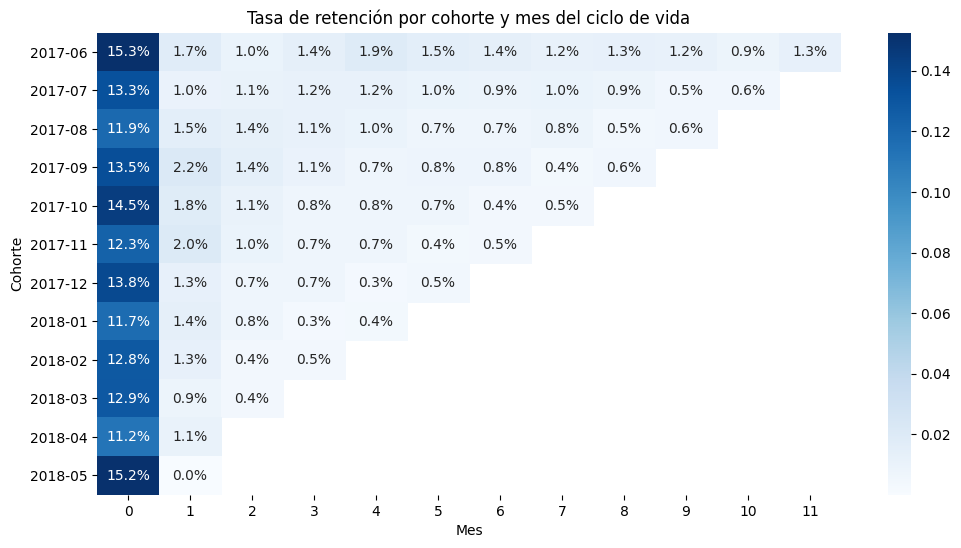

In [35]:
# Visualiza información de conversión de cohortes 
pivot_table = conversion.pivot_table(index='cohort_visit', 
                                    columns='cohort_lifetime', 
                                    values='conv_rate')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".1%")
plt.title("Tasa de retención por cohorte y mes del ciclo de vida")
plt.ylabel("Cohorte")
plt.xlabel("Mes")
plt.show()

Los valores de retención son relativamente bajos, la proporción de usuarios iniciales de la cohorte que regresa cada mes siguiente está entre el 11% y el 15% en el mes cero y caen significativamente los meses siguientes, o sea, que son muy pocos los usuarios que regresan luego del primer mes. 

La cohorte con mejor desempeño es 2017-06, y aunque todas presentan una tendencia similar, las retenciones en la primera cohorte son mayores que las otras a lo largo del ciclo de vida manteniéndose sobre el 1%, incluso en el mes 11. 
Despues del primer mes, menos del 3% de los usuarios se mantienen activos en los meses siguientes y después del sexto mes, lo hace menos del 1.4%.

In [36]:
# Usuarios convertidos por día en cohort_life=0

# Estima usuarios base por días de conversión, tamaño de la cohorte
initial_conv_days = visits_orders.groupby(
    'conversion_days')['uid'].nunique().reset_index(name='init_users')
# Calcula usuarios convertidos de cada cohorte
converted_conv_days = converted_users.groupby(['conversion_days', 
      'cohort_lifetime'])['uid'].nunique().reset_index(name='conv_users')
converted_users_month0 = converted_conv_days[converted_conv_days['cohort_lifetime'] == 0]
# Une usuarios iniciales con convertidos
conversion_month0 = pd.merge(initial_conv_days, converted_users_month0,
                             on=['conversion_days'])
# Calcula tasa de conversión
conversion_month0['conv_rate'] = (conversion_month0['conv_users'] / 
                                  conversion_month0['init_users'])

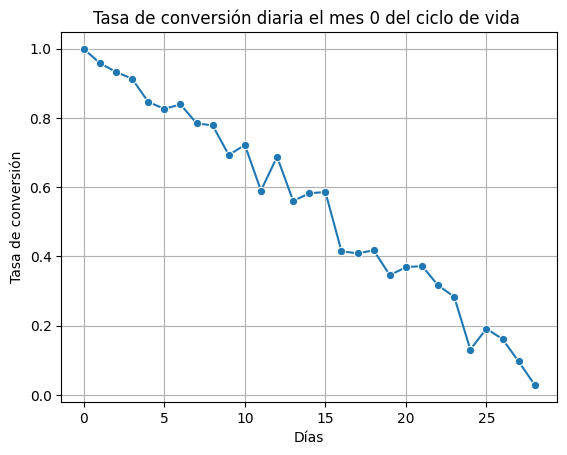

In [37]:
# Visualiza tasa de conversión por día en el primer mes de compra
sns.lineplot(data=conversion_month0, x='conversion_days', y='conv_rate', marker='o')
plt.title('Tasa de conversión diaria el mes 0 del ciclo de vida ')
plt.xlabel('Días')
plt.ylabel('Tasa de conversión')
plt.grid(True)
plt.show()

Veamos la tasa de conversión en el mes cero del ciclo de vida, casi la totalidad de los usuarios convierten el mismo día que ingresan y durante los días siguientes las tasas de conversión caen rápidamente.

In [38]:
# Conversión por fuente de marketing
# Estima usuarios base por canal de marketing, tamaño de la cohorte
initial_source = visits_orders.groupby(
    ['source_id'])['uid'].nunique().reset_index(name='init_users')
# Calcula usuarios convertidos por fuente en cada mes
converted_source = converted_users.groupby(
    ['source_id', 'order_month'])['uid'].nunique().reset_index(name='conv_users')
# Une usuarios iniciales con convertidos
conversion_by_source = pd.merge(initial_source, converted_source, 
                                on=['source_id'], how='left')
# Calcula tasa de conversión
conversion_by_source['conv_rate'] = (conversion_by_source['conv_users'] / conversion_by_source['init_users'])

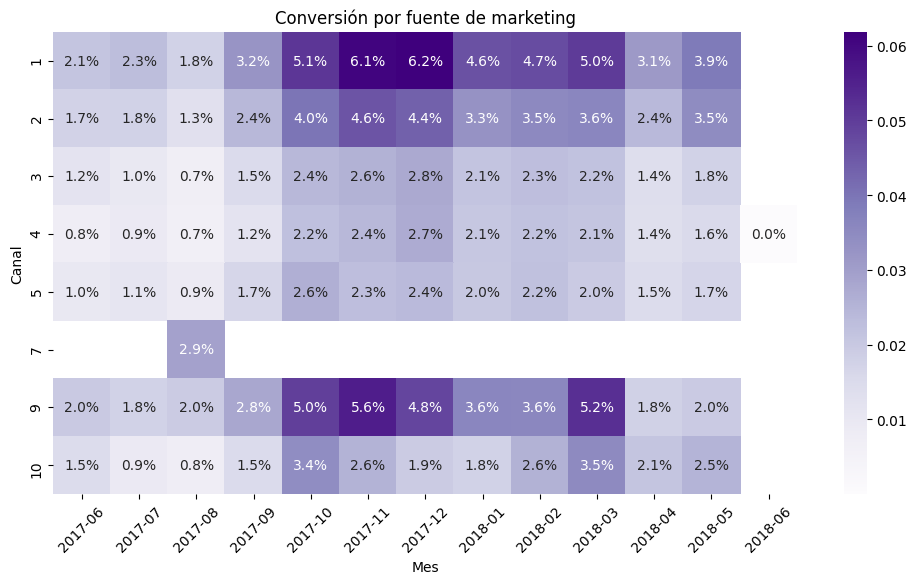

In [39]:
# Visualiza información de conversión por fuente y mes
# Crea tabla dinámica
pivot_table1 = conversion_by_source.pivot_table(index='source_id', 
                                    columns='order_month', 
                                    values='conv_rate')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table1, cmap='Purples', annot=True, fmt=".1%")
plt.title("Conversión por fuente de marketing")
plt.ylabel("Canal")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.show()

La fuente 1 presenta las retenciones más altas en todo el período; le siguen en su orden, la fuente 9 también con un notable desempeño, la fuente 2 y la fuente 10.
Los meses con las mejores tasas de retención por fuente están entre octubre y marzo.

In [40]:
# ¿Cuántos pedidos hacen durante un tiempo dado?
# Crea cohortes mensuales de clientes
visits_orders['cohort_cust'] = visits_orders['first_order_day'].dt.to_period('M')

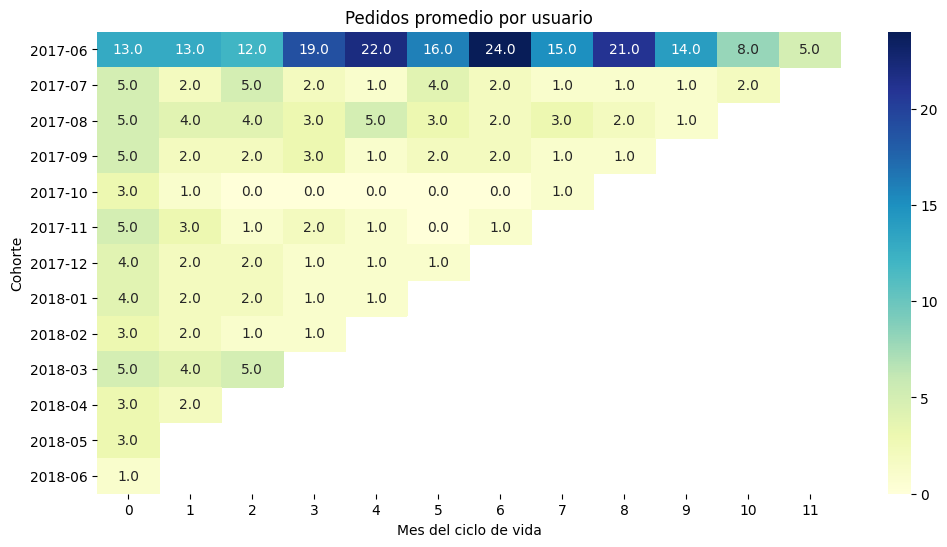

In [41]:
# Estima el número de usuarios por cohorte
cohort_sizes = visits_orders.groupby(
    'cohort_cust')['uid'].nunique().reset_index(name='n_users')
# Calcula el número de órdenes mensuales por cohorte
cohorts_orders = visits_orders.groupby(
    ['cohort_cust', 'order_month'])['buy_ts'].count().reset_index(name='n_orders')
# Une el número de usuarios con las órdenes 
orders_report = pd.merge(cohort_sizes, cohorts_orders, on='cohort_cust')
# Crea columna con el número de pedidos por cliente  
orders_report['oders_per_user'] = orders_report['n_orders'] / orders_report['n_users']
# Determina los meses del ciclo de vida de la cohorte
orders_report['cohort_lifetime'] = (
    orders_report['order_month'] - orders_report['cohort_cust']).apply(attrgetter('n'))
# Crea una tabla dinámica
orders_result = orders_report.pivot_table(
    index='cohort_cust', columns='cohort_lifetime', values='oders_per_user', aggfunc='mean'
).round()
# Visualización de tabla dinámica
plt.figure(figsize=(12, 6))
sns.heatmap(orders_result, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title("Pedidos promedio por usuario")
plt.ylabel("Cohorte")
plt.xlabel("Mes del ciclo de vida")
plt.show()

La cohorte 2017-06 es la más antigua, la más activa y la de mayores pedidos por cliente con un comportamiento sostenido durante el ciclo de vida y picos en los meses 6, 4 y 8.
Se observa que las cohortes más antiguas tienen un mayor número de pedidos por cliente que las más nuevas y aunque tienden a disminuir con el tiempo, en estas últimas la caída es más rápida, además el patrón de crecimiento no es tan fuerte como el de la primera.

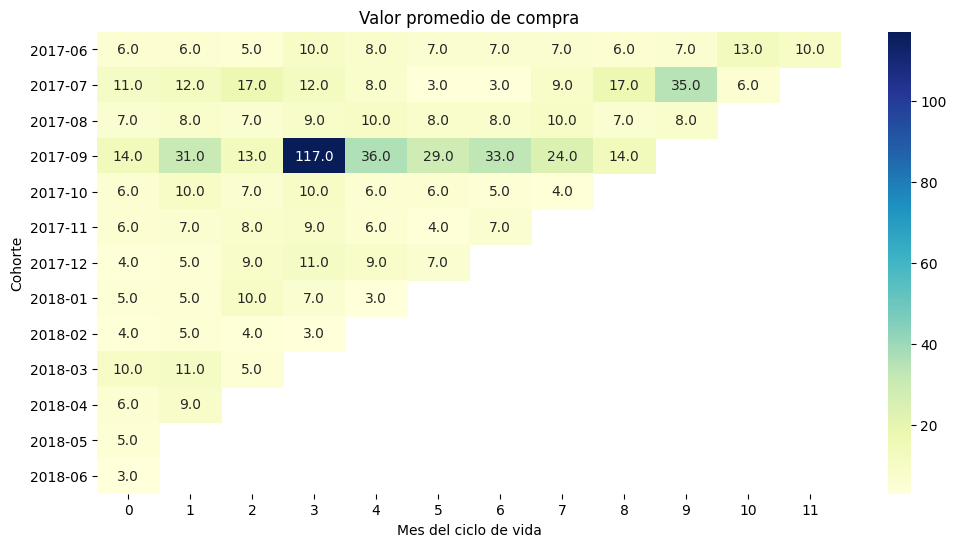

In [42]:
#¿Cuál es el tamaño promedio de compra?
# AOV average order value
# Calcula los ingresos mensuales y el número de órdenes por cohorte 
cohorts_revenue = visits_orders.groupby(
    ['cohort_cust', 'order_month']).agg({'revenue': 'sum', 'buy_ts': 'count'}).reset_index()
# Asigna nombres a las columnas resultantes
cohorts_revenue.columns = ['cohort_cust', 'order_month', 'revenue', 'n_orders']
# Crea columna con el valor de los ingresos por orden  
cohorts_revenue['aov'] = cohorts_revenue['revenue'] / cohorts_revenue['n_orders']
# Determina los meses del ciclo de vida de la cohorte
cohorts_revenue['cohort_lifetime'] = (
    cohorts_revenue['order_month'] - cohorts_revenue['cohort_cust']).apply(attrgetter('n'))
# Crea una tabla dinámica
aov_result = cohorts_revenue.pivot_table(
    index='cohort_cust', columns='cohort_lifetime', values='aov', aggfunc='mean'
).round()
# Visualización de tabla dinámica
plt.figure(figsize=(12, 6))
sns.heatmap(aov_result, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title("Valor promedio de compra")
plt.ylabel("Cohorte")
plt.xlabel("Mes del ciclo de vida")
plt.show()

Los valores promedio de compra más elevados se presentan en la cohorte 2017-09 con un pico inusual en el mes 3 debido a máximos en compras con respecto a un número de órdenes relativamente bajo, situación que se repite en el mes 9 en la cohorte 2017-07.  Esta última, aunque presenta valores más altos que la primera cohorte, tiene un comportamiento irregular. La primera cohorte, 2017-06, muestra usuarios con un gasto consistente los cuales se incrementaron durante los dos últimos meses.
Las demás cohortes tienen valores promedio entre 3 usd y 11 usd y muestran estabilidad.


Para efectos didácticos, las estimaciones de LTV realizadas a continuación están basadas solamente en los ingresos por ventas sin tener en cuenta un margen de rentabilidad, por lo cual el ROMI calculado es un ROMI basado en ingresos brutos y no refleja una rentabilidad neta.

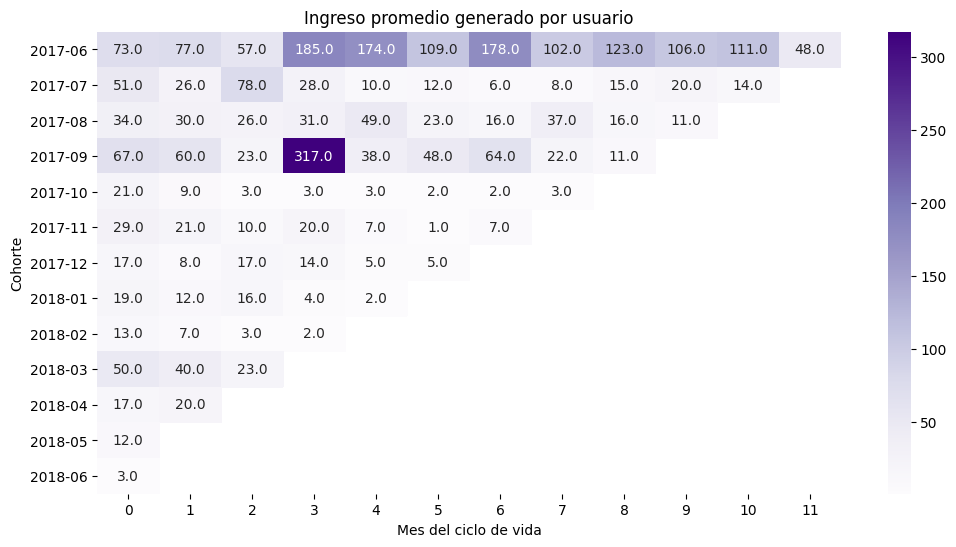

In [43]:
# ¿Cuánto dinero traen? (LTV)

# Calcula los ingresos por mes de cada cohorte
cohorts_revenue = visits_orders.groupby(
    ['cohort_cust', 'order_month'])['revenue'].sum().reset_index()
# Une el número de usuarios de la cohorte con los ingresos 
report = pd.merge(cohort_sizes, cohorts_revenue, on='cohort_cust')
# Crea columna con el calculo de ltv
report['ltv'] = report['revenue'] / report['n_users']
# Determina los meses del ciclo de vida de la cohorte
report['cohort_lifetime'] = (
    report['order_month'] - report['cohort_cust']).apply(attrgetter('n'))
# Crea una tabla dinámica
result = report.pivot_table(
    index='cohort_cust', columns='cohort_lifetime', values='ltv', aggfunc='mean'
).round()
# Visualización de tabla dinámica
plt.figure(figsize=(12, 6))
sns.heatmap(result, cmap='Purples', annot=True, fmt='.1f')
plt.title("Ingreso promedio generado por usuario")
plt.ylabel("Cohorte")
plt.xlabel("Mes del ciclo de vida")
plt.show()

In [44]:
# Muestra LTV por cohorte
ltv_by_cohort = result.sum(axis=1)
ltv_by_cohort

cohort_cust
2017-06    1343.0
2017-07     268.0
2017-08     273.0
2017-09     650.0
2017-10      46.0
2017-11      95.0
2017-12      66.0
2018-01      53.0
2018-02      25.0
2018-03     113.0
2018-04      37.0
2018-05      12.0
2018-06       3.0
Freq: M, dtype: float64

La cohorte más activa y la de mayores ingresos en su ciclo de vida es la primera, 2017-06, las cohortes 2017-07 y 2017-09 también muestran valores interesantes pero más irregulares. Las demás cohortes parecen tener menores ingresos, aunque la 2018-03 en tan solo 3 meses ha demostrado un comportamiento llamativo.

En la cohorte 2017-06, cada cliente en promedio generó 1343 usd en ingresos en doce meses.  La cohorte 2019-09 generó ingresos por 650 usd por cliente en nueve meses, le siguen las cohortes 2017-07 y 2017-08 con ingresos de 268 usd y 273 usd, respectivamente.

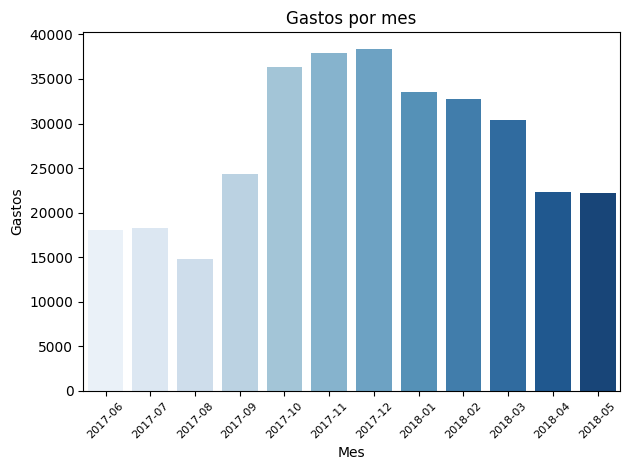

In [45]:
# ¿Cuánto dinero se gasto?
# Gasto total, por fuente de adquisición, a los largo del tiempo

# Crea columna con el mes
costs_df['month'] = costs_df['dt'].dt.to_period('M')
# Calcula gastos por mes   
monthly_costs = costs_df.groupby('month')['costs'].sum().reset_index()
sns.barplot(data=monthly_costs, x='month', y='costs', ci=None, palette='Blues')
plt.title('Gastos por mes')
plt.xlabel('Mes')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('Gastos')
plt.tight_layout()
plt.show()

In [46]:
# Calcula gastos totales de marketing
total_costs = monthly_costs['costs'].sum().round()
total_costs

329132.0

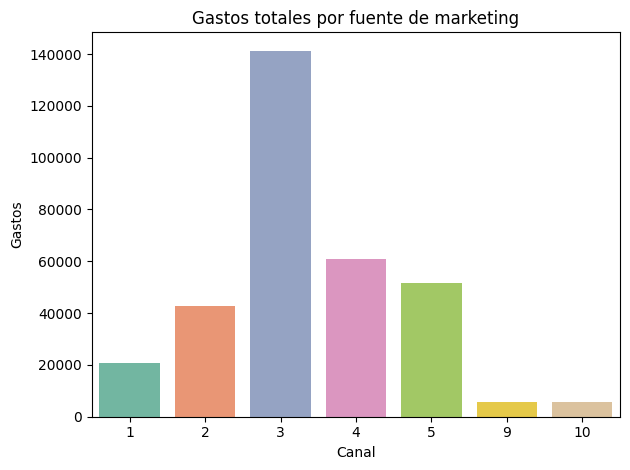

In [47]:
# Calcula gastos por fuente de adquisición
costs_by_source = costs_df.groupby('source_id')['costs'].sum().reset_index()
sns.barplot(data=costs_by_source, x='source_id', y='costs', ci=None, palette='Set2')
plt.title('Gastos totales por fuente de marketing')
plt.xlabel('Canal')
plt.ylabel('Gastos')
plt.tight_layout()
plt.show()

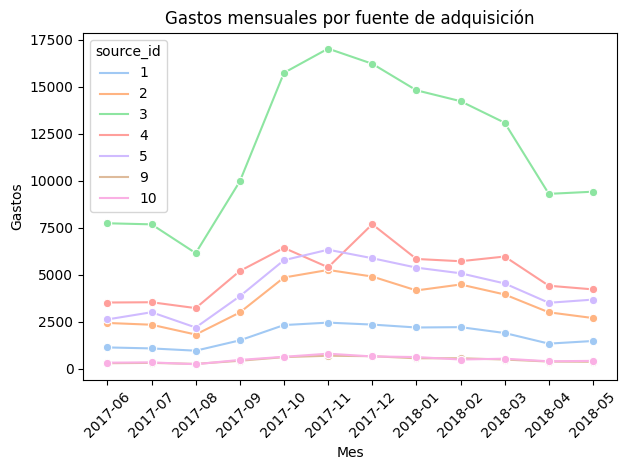

In [48]:
# Calcula gastos mensuales por fuente de adquisición
source_costs_by_month = costs_df.groupby(['source_id', 'month'])['costs'].sum().reset_index()
source_costs_by_month['month'] = source_costs_by_month['month'].astype(str)
sns.lineplot(data=source_costs_by_month, x='month', y='costs', 
             hue='source_id', palette='pastel', marker='o')
plt.title('Gastos mensuales por fuente de adquisición')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.ylabel('Gastos')
plt.tight_layout()
plt.show()


Los gastos totales en marketing durante junio de 2017 y mayo de 2018 fueron de \$392.132, de los cuales, el 43% fue para la fuente 3 y un 19% y 16% para las fuentes 4 y 5 respectivamente. En términos generales, los gastos se incrementan a partir de septiembre hasta el fín de año y descienden progresivamente en 2018.

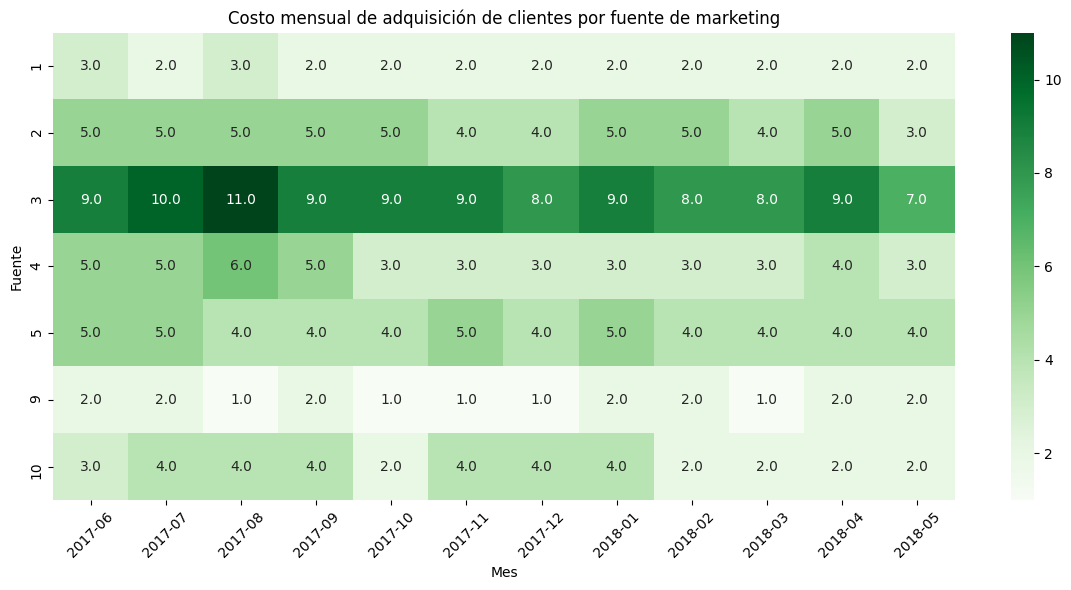

In [49]:
# ¿Cuál fue el costo de adquisición de clientes CAC de cada una de las fuentes?

# Estima el número de compradores por mes por fuente
source_sizes = visits_orders.groupby(
    ['source_id', 'order_month'])['uid'].nunique().reset_index(name='source_users')
# Une el número de compradores de cada fuente con los gastos 
# Convierte a 'period[M]' el tipo de 'month' para igualarlo con el de 'order_month'
source_costs_by_month['month'] = source_costs_by_month['month'].astype('period[M]')
cac_report = pd.merge(source_sizes, source_costs_by_month, 
                      left_on=['source_id', 'order_month'], right_on=['source_id', 'month'])
# Crea columna con el calculo de cac
cac_report['cac'] = cac_report['costs'] / cac_report['source_users']
# Crea tabla dinámica
cac_result = cac_report.pivot_table(
    index='source_id', columns='month', values='cac', aggfunc='mean'
).round()
# Visualiza tabla dinámica a través de un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cac_result, cmap='Greens', annot=True, fmt='.1f')
plt.title("Costo mensual de adquisición de clientes por fuente de marketing")
plt.ylabel("Fuente")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las fuentes 9 y 1 son las que adquieren clientes a más bajo costo y de manera consistente, estas son las más eficientes.  La fuente 10 presenta mejores cac a partir de febrero. Los costos más elevados se encuentran en la fuente 3, definitivamente la más costosa.

In [50]:
# Romi mensual por fuente
# Estima número de clientes y los ingresos por fuente y mes
source_report = visits_orders.groupby(
    ['source_id', 'order_month', ]).agg(source_users=('uid', 'nunique'),
    revenue=('revenue', 'sum')).reset_index()
# Calcula costos mensuales por fuente
# source_costs_by_month = costs_df.groupby(['source_id', 'month'])['costs'].sum().reset_index()
source_report_ = pd.merge(source_report, source_costs_by_month, left_on=['source_id', 'order_month'], right_on=['source_id', 'month'])
# Calcula en nuevas columnas ltv, cac y romi por fuente y mes
source_report_['ltv'] = source_report_['revenue'] / source_report_['source_users']
source_report_['cac'] = source_report_['costs'] / source_report_['source_users']
source_report_['romi'] = source_report_['ltv'] / source_report_['cac']

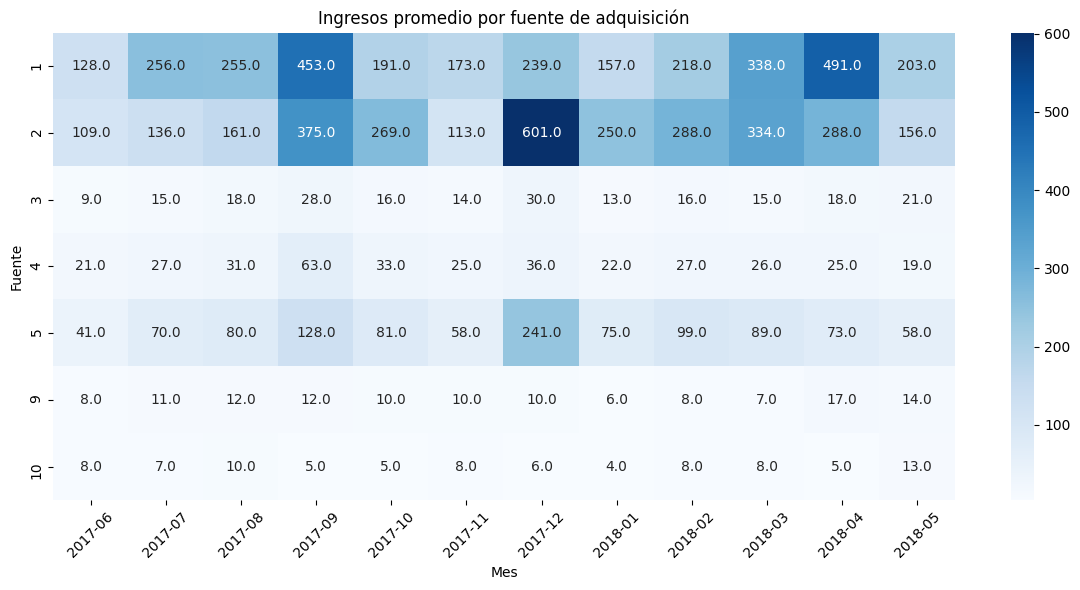

In [51]:
# Crea tabla dinámica ltv mensual por fuente
source_result_ltv = source_report_.pivot_table(
    index='source_id', columns='order_month', values='ltv', aggfunc='mean'
).round()
# Visualiza ltv mensual por fuente
plt.figure(figsize=(12, 6))
sns.heatmap(source_result_ltv, cmap='Blues', annot=True, fmt='.1f')
plt.title("Ingresos promedio por fuente de adquisición")
plt.ylabel("Fuente")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La fuente 1 es la de mayores ingresos con valores muy altos en abril, septiembre y marzo.  La fuente 2 también es de las más rentables, con un pico muy elevado en diciembre, sigue la fuente 5 con ingresos menores a la mitad de la anterior. 

In [52]:
# Crea tabla dinámica cac mensual por fuente
source_result_cac = source_report_.pivot_table(
    index='source_id', columns='order_month', values='cac', aggfunc='mean'
).round()
# Visualiza ltv mensual por fuente
#plt.figure(figsize=(12, 6))
#sns.heatmap(source_result_cac, cmap='Greens', annot=True, fmt='.1f')
#plt.title("Costo de adquisición de clientes por fuente de marketing")
#plt.ylabel("Fuente")
#plt.xlabel("Mes")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

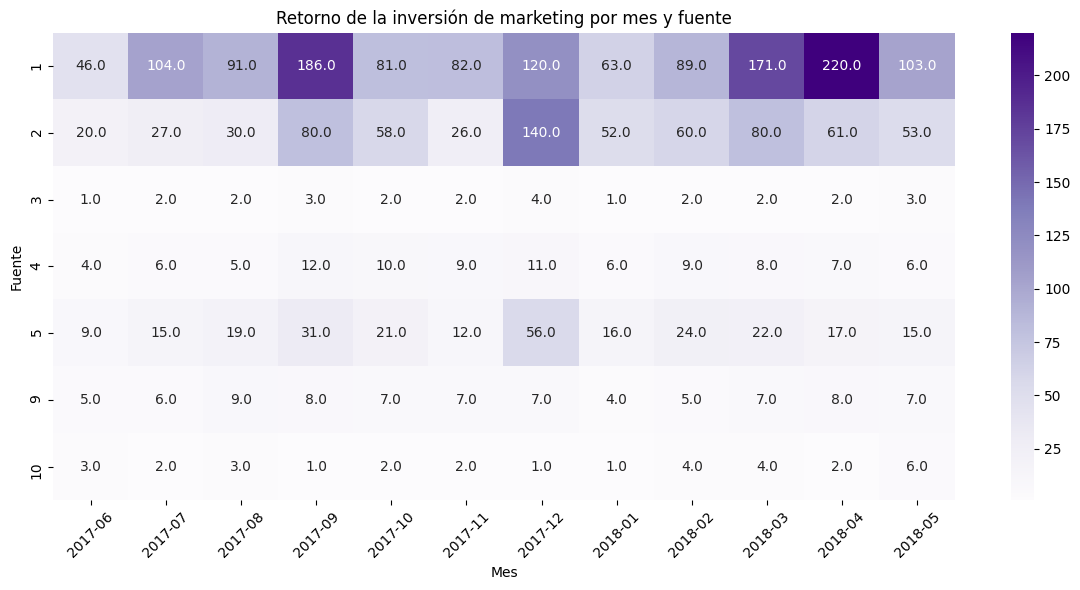

In [53]:
# Crea tabla dinámica romi mensual por fuente
source_result_romi = source_report_.pivot_table(
    index='source_id', columns='order_month', values='romi', aggfunc='mean'
).round()
# Visualiza ltv mensual por fuente
plt.figure(figsize=(12, 6))
sns.heatmap(source_result_romi, cmap='Purples', annot=True, fmt='.1f')
plt.title("Retorno de la inversión de marketing por mes y fuente")
plt.ylabel("Fuente")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La fuente 1 tiene los mejores valores en retorno de la inversión, los ingresos altos con costos bajos y estables hacen de esta fuente la más rentable.  
La fuente 2 presenta también un romi interesante con buenos ingresos, pero los cac elevados hacen que sea menos eficiente que la fuente anterior.   
La fuente 3 es la más costosa con un retorno muy bajo.  
La fuente 4 tiene ingresos y costos moderados pero un retorno bajo.  
La fuente 5 presenta buen rendimiento con retornos interesantes sobre todo en algunos meses.  
La fuente 9 aunque tiene los costos más bajos de igual manera son sus ingresos y rendimientos.   
La fuente 10 es la de menores ingresos generando un romi muy bajo.


Estacionalmente, los romi mas altos se obtuvieron en diciembre y septiembre, siendo más evidente en las fuentes 1, 2 y 5.



<div style="margin-top: 40px;">
A continuación se calculan las métricas de rentabilidad para varios dispositivos, ya que con la información disponible no es posible asociar directamente sus costos se asumirá su proporción a partir de las órdenes de compra.
</div>


In [54]:
# Romi, ltv y cac mensual por dispositivo
# Estima número de clientes y los ingresos por dispositivo y mes
device_report = visits_orders.groupby(
    ['device', 'order_month', ]).agg(source_users=('uid', 'nunique'),
    revenue=('revenue', 'sum')).reset_index()
# Calcula costos mensuales por dispositivo
# Estima la participación de cada dispositivo en las órdenes mensuales
device_share = visits_orders.groupby(
    ['order_month', 'source_id', 'device'])['buy_ts'].count().reset_index(name='order_count')
# Calcula el total por mes y fuente
device_share['total'] = device_share.groupby(
    ['order_month', 'source_id'])['order_count'].transform('sum')
# Calcula la participación de los dispositivos por en mes y fuente
device_share['percent'] = device_share['order_count'] / device_share['total'] * 100
# Obtiene costos por dispositivo para cada mes y fuente
device_costs = pd.merge(costs_df, device_share, how='left', 
                        left_on=['source_id', 'month'], 
                        right_on=['source_id', 'order_month'])
# Crea una columna con los costos por dispositivo
device_costs['costs_per_device'] = device_costs['costs'] * device_costs['percent'] / 100
# Obtiene costos totales por dispositivo y mes
device_costs_monthly = device_costs.groupby(
    ['device', 'order_month'])['costs_per_device'].sum().reset_index(name='costs').round()
# Une datasets de ingresos y costos
device_report_ = pd.merge(device_report, 
                          device_costs_monthly, how='left', 
                          on=['device', 'order_month'])
# Calcula en nuevas columnas ltv, cac y romi por fuente y mes
device_report_['ltv'] = device_report_['revenue'] / device_report_['source_users']
device_report_['cac'] = device_report_['costs'] / device_report_['source_users']
device_report_['romi'] = device_report_['ltv'] / device_report_['cac']
device_report_.sample(3)

,device,order_month,source_users,revenue,costs,ltv,cac,romi
12,desktop,2018-06,1,3.42,NaN,3.420000,NaN,NaN
13,touch,2017-06,454,11452.97,1640.0,25.226806,3.612335,6.983518
1,desktop,2017-07,1655,239453.24,16292.0,144.684737,9.844109,14.697596


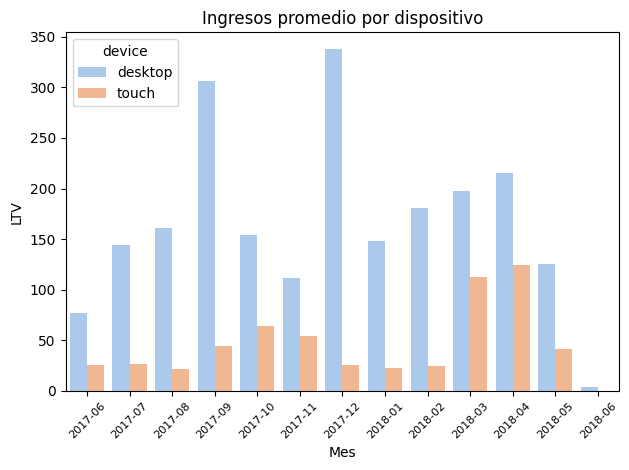

In [55]:
# Visualiza ltv mensual por dispositivo
device_report_['order_month'] = device_report_['order_month'].astype(str)
sns.barplot(data=device_report_, x='order_month', y='ltv', 
             hue='device', palette='pastel')
plt.title('Ingresos promedio por dispositivo')
plt.xlabel('Mes')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('LTV')
plt.tight_layout()
plt.show()


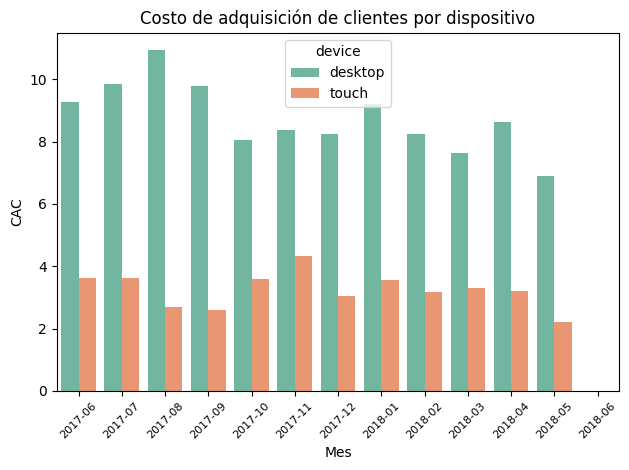

In [56]:
# Gráfico de cac mensual por dispositivo
sns.barplot(data=device_report_, x='order_month', y='cac', 
             hue='device', palette='Set2')
plt.title('Costo de adquisición de clientes por dispositivo')
plt.xlabel('Mes')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('CAC')
plt.tight_layout()
plt.show()

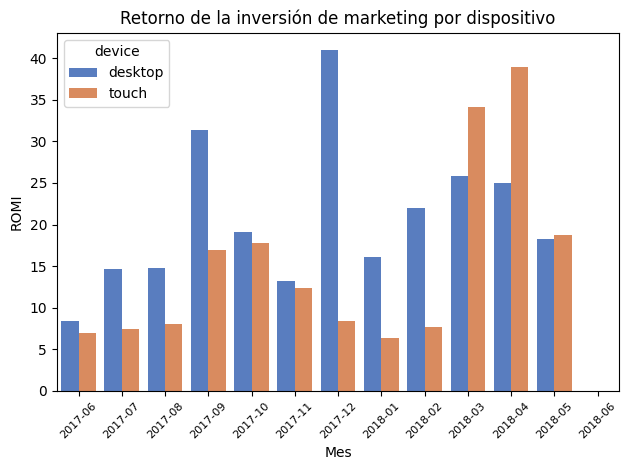

In [57]:
# Gráfico de romi mensual por dispositivo
sns.barplot(data=device_report_, x='order_month', y='romi', 
             hue='device', palette='muted')
plt.title('Retorno de la inversión de marketing por dispositivo')
plt.xlabel('Mes')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('ROMI')
plt.tight_layout()
plt.show()

Desktop tiene un volumen de usuarios mucho mayor que Touch, los ingresos superan los del otro dispositivo durante todos los meses, alcanzando picos altos en septiembre y diciembre. El cac es relativamente estable y el retorno de la inversión es consistente, siendo mayor que el de Touch en casi todo el período.  Touch, aunque tiene ingresos menores que Desktop, su bajo cac contribuye a que el romi sea equilibrado, inclusive, que sea más rentable en los últimos tres meses.  

### Conclusiones ###

Del análisis de las métricas anteriores se identificaron los siguientes puntos clave:

Fuentes:
La más recomendada es la fuente 1 gracias a un retorno de la inversión alto y consistente, como resultado de los altos ingresos y costos bajos y estables.  

La fuente 2 también presenta una elevada rentabilidad y podría ser optimizada luego de la revisión de los costos de adquisición de clientes.  

La fuente 5 tiene ingresos y costos medios, muestra buen desempeño con un gran potencial.

Por otro lado, es necesario evaluar la permanencia o reestructuración de la fuente 3, una fuente poco eficiente, costosa y de bajo retorno. 

Cohortes:
La primera cohorte, 2017-06, es la de mayor desempeño y solidez, sus tasas de retención son más altas que las de las otras cohortes así como los ingresos y los pedidos por cliente. 

Las cohortes 2017-09 y 2017-07 tienen muy buenos ingresos, altos valores promedio de compra y un bajo número de pedidos.

Vale la pena analizar la cohorte 2018-03, a pesar de su corto ciclo de vida sus ingresos son mas altos que los de las cohortes cercanas.

Dispositivos:
Desktop: Los usuarios son altamente rentables, presentan una excelente relación costo-beneficio, alto valor estratégico.
Touch: aunque sus ingresos son limitados, su bajo CAC les permite ser rentables en algunos meses, tiene potencial en períodos específicos.

Conversión:
Dado el rápido tiempo de conversión, se debería enfatizar en optimizar el contacto inicial.  



In [126]:
# PASOS PREVIOS AL LTV

# Cargar datos de visitas desde un archivo CSV
visits = pd.read_csv('/datasets/visits_log_us.csv')

# Convertir las columnas de tiempos de inicio y fin de las visitas al formato de fecha y hora
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format="%Y.%m.%d %H:%M:%S")
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format="%Y.%m.%d %H:%M:%S")

# Renombrar las columnas para mayor claridad
visits = visits.rename(columns={"Device": "device", "End Ts": "session_end_ts", 
                                "Source Id": "source_id", "Start Ts": "session_start_ts", "Uid": "uid"})

# Extraer el mes, la semana y la fecha de inicio de sesión
visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['session_start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['session_start_ts'].dt.date

# Encontrar la primera visita de cada usuario
first_visits = visits.groupby('uid').agg({'session_start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_session_start_ts']

# Extraer la fecha y el mes de la primera sesión
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')

# Combinar los datos de las primeras visitas con los datos completos de visitas
visits_full = pd.merge(first_visits, visits, on='uid')

# Calcular la diferencia en meses entre la primera visita y las visitas subsiguientes
visits_full['age_months'] = ((visits_full['session_month'] - visits_full['first_session_month']) / 
                             np.timedelta64(1, 'M')).round().astype('int')

# Cargar datos de pedidos desde un archivo CSV
orders = pd.read_csv('/datasets/orders_log_us.csv')
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
orders = orders.rename(columns={"Buy Ts": "buy_ts", "Revenue": "revenue", "Uid": "uid"})

# Extraer el día y el mes de compra
orders['buy_dt'] = orders['buy_ts'].dt.date
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

# Encontrar la primera compra de cada usuario
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')

# Crear un dataframe con las primeras órdenes y las primeras visitas
buyers = pd.merge(first_visits, first_orders, on='uid')
buyers['first_order_dt'] = pd.to_datetime(buyers['first_order_dt'])
buyers['first_session_dt'] = pd.to_datetime(buyers['first_session_dt'])

# Calcular los días hasta la primera compra
buyers['days_to_first_purchase'] = ((buyers['first_order_ts'] - buyers['first_session_start_ts']) / 
                                    np.timedelta64(1, 'D')).astype('int')

In [ ]:
# LTV
# Determinar el tamaño de cada cohorte de compradores
# Agrupa a los compradores por el mes de su primera compra y cuenta los usuarios únicos en cada grupo.
cohort_sizes = buyers.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
# Renombra la columna 'uid' a 'n_buyers' para indicar el número de compradores únicos.
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

# Fusionar las órdenes y compradores, y calcular ingresos por cohorte
# Une los DataFrames 'orders' y 'buyers' usando 'uid' como clave, y agrupa el resultado por mes de la primera orden y mes de orden.
# Calcula la suma de los ingresos para cada grupo.
cohorts = pd.merge(orders, buyers, how='inner', on='uid')\
            .groupby(['first_order_month', 'order_month'])\
            .agg({'revenue': 'sum'}).reset_index()

# Calcular la antigüedad de las cohortes
# Calcula la 'edad' de cada cohorte desde su primera compra, en meses.
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')).round()
# Actualiza los nombres de las columnas para reflejar los datos que contienen.
cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'age_month']

# Crear el informe de cohortes y calcular el LTV
# Une 'cohort_sizes' con 'cohorts' usando 'first_order_month' como clave.
# Calcula el LTV dividiendo los ingresos por el número de compradores.
cohorts_report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
cohorts_report['ltv'] = cohorts_report['revenue'] / cohorts_report['n_buyers']

# Preparar la tabla pivote para la visualización
# Crea una tabla pivote para visualizar el LTV de cada cohorte por su 'edad' en meses.
cohorts_ltv = cohorts_report.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)
# Redondea los valores a dos decimales y reemplaza los NaN por 0.
cohorts_ltv = cohorts_ltv.round(2)
# Convierte los índices de 'first_order_month' a cadena para mejorar la visualización en el heatmap.
cohorts_ltv.index = cohorts_ltv.index.astype(str)

# Visualización del Heatmap del LTV
# Visualiza el LTV de las cohortes usando un mapa de calor.
plt.figure(figsize=(10, 6))  # Aumenta el tamaño de la figura si es necesario
ax = sns.heatmap(cohorts_ltv, annot=True, fmt=".2f", linewidths=0.5,
                 cbar_kws={'label': 'Lifetime Value (LTV)'}, annot_kws={"size": 9})
plt.title('LTV by Cohort')
plt.xlabel('Age (months)')
plt.ylabel('Cohort (First Order Month)')

In [ ]:
# COSTOS
# Cargar datos de costos desde un archivo CSV
costs = pd.read_csv('/datasets/costs_us.csv')
costs['dt'] = pd.to_datetime(costs['dt'])
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

# Calcular el CAC medio
print("CAC medio es:", round(costs['costs'].sum() / orders['uid'].nunique(), 2))

# Calcular el CAC por mes
CAC_by_month = pd.merge(costs.groupby('costs_month').agg({'costs': 'sum'}),
                        buyers.groupby('first_order_month').agg({'uid': 'nunique'}),
                        left_index=True, right_index=True)
CAC_by_month['cac'] = CAC_by_month['costs'] / CAC_by_month['uid']

# Gráfico del CAC promedio por mes
CAC_by_month['cac'].plot(figsize=(14, 7), title='CAC promedio por mes', xlabel='Mes', ylabel='c.u.')

# Encontrar la primera fuente por visitante
users = visits_full.sort_values('session_start_ts').groupby('uid').first()
users = users[['source_id']]
buyers = pd.merge(buyers, users, left_on='uid', right_index=True)
buyers_daily = buyers.groupby(['source_id', 'first_order_dt']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])

# Calcular el CAC diario por fuente
costs_ = pd.merge(buyers_daily, costs, left_on=['source_id', 'first_order_dt'], right_on=['source_id', 'dt'])
costs_['cac'] = costs_['costs'] / costs_['n_buyers']

# Gráfico de CAC diario por fuente y mes
costs_.pivot_table(index=['costs_month'], columns='source_id', values='cac', aggfunc='mean').plot(
    figsize=(16, 9), title='CAC por comprador de cada fuente', xlabel='Mes', ylabel='c.u.')
plt.show()

# Calcular el CAC promedio por fuente
cac_by_source = costs_.groupby('source_id').agg({'cac': 'mean'}).round(2)
print(cac_by_source)

In [ ]:
# ROMI
# Calcular ingresos mensuales por usuario
month_revenue = orders.groupby(['uid', 'order_month']).agg({'revenue': 'sum'}).reset_index()
buyers = buyers.merge(month_revenue, on='uid')

# Iterar a través de cada fuente de tráfico, excepto la fuente número 7
for source, df in buyers.groupby('source_id'):
    if source != 7:
        # Calcular el tamaño de la cohorte para cada fuente y mes de la primera orden
        cohort_sizes_t = (
            df.groupby(['source_id', 'first_order_month'])
            .agg({'uid': 'nunique'})
            .reset_index()
        )
        cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

        # Calcular los ingresos totales por cohorte
        cohorts_revenue_t = (
            df.groupby(['source_id', 'first_order_month', 'order_month'])
            .agg({'revenue': 'sum'})
            .reset_index()
        )
        cohorts_revenue_t.columns = ['source_id', 'first_order_month', 
                                     'order_month', 'gp']

        # Fusionar los tamaños de las cohortes con los ingresos por cohortes
        report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])
        report_romi['age'] = (
            report_romi['order_month'] - report_romi['first_order_month']
        ) / np.timedelta64(1, 'M')
        report_romi['age'] = report_romi['age'].round().astype('int')
        report_romi['ltv'] = report_romi['gp'] / report_romi['n_buyers']

        # Calcular costos y CAC para cada cohorte
        report_romi = pd.merge(report_romi, costs.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
                               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])
        report_romi = report_romi.drop(['costs_month'], axis=1)
        report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
        report_romi['romi'] = report_romi['ltv'] / report_romi['cac']

        # Crear una tabla pivote de ROMI por edad para cada cohorte
        romi = report_romi\
                .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
                .cumsum(axis=1)
        romi.round(2).fillna('')

        # Configurar el índice como cadena para un mejor formato
        romi.index = romi.index.astype(str)

        # Visualizar el ROMI utilizando un mapa de calor
        sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws={'orientation': 'horizontal'}
                    ).set(title='ROMI por fuente {}'.format(source))
        plt.show()

In [58]:
# Pasos previos a ltv
# Encontrar la primera visita de cada usuario: first_visits
# Extraer la fecha y el mes de la primera sesión
first_visits['first_visit_day'] = first_visits['first_visit_day'].dt.date
first_visits['first_visit_month'] = first_visits['first_visit_day'].astype('datetime64[M]')

# Combinar los datos de las primeras visitas con los datos completos de visitas
visits_full = pd.merge(first_visits, visits_df, on='uid')

# Extraer el día y el mes de compra
orders_df['buy_dt'] = orders_df['buy_ts'].dt.date
orders_df['order_month'] = orders_df['buy_ts'].astype('datetime64[M]')

# Encontrar la primera compra de cada usuario: first_orders_date
first_orders_date['first_order_day'] = first_orders_date['first_order_day'].dt.date
first_orders_date['first_order_month'] = first_orders_date['first_order_day'].astype('datetime64[M]')

# Crear un dataframe con las primeras órdenes y las primeras visitas
buyers = pd.merge(first_visits, first_orders_date, on='uid')
buyers['first_order_day'] = pd.to_datetime(buyers['first_order_day'])
buyers['first_visit_day'] = pd.to_datetime(buyers['first_visit_day'])


Text(95.72222222222221, 0.5, 'Cohort (First Order Month)')

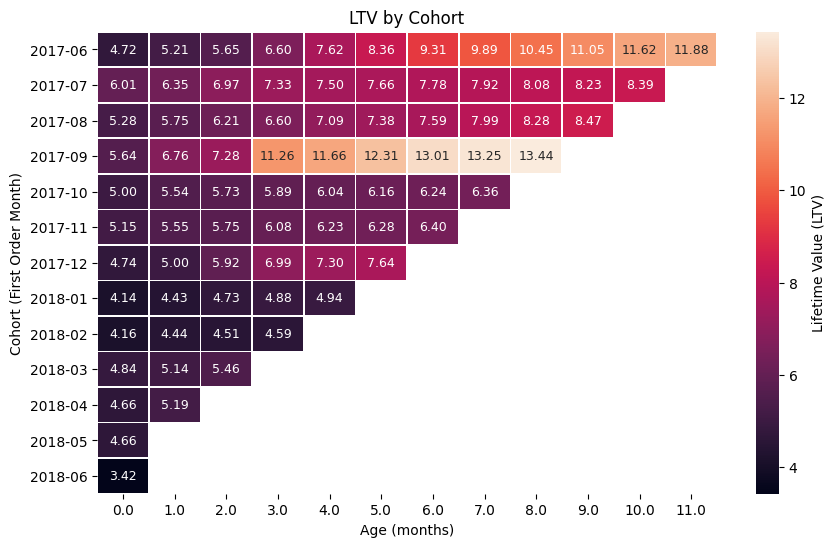

In [59]:
# LTV
# Determinar el tamaño de cada cohorte de compradores: cohort_sizes
# Fusionar las órdenes y compradores, y calcular ingresos por cohorte
# Une los DataFrames 'orders' y 'buyers' usando 'uid' como clave, y agrupa el resultado por mes de la primera orden y mes de orden.
# Calcula la suma de los ingresos para cada grupo.
cohorts = pd.merge(orders_df, buyers, how='inner', on='uid')\
            .groupby(['first_order_month', 'order_month'])\
            .agg({'revenue': 'sum'}).reset_index()
# Calcula la 'edad' de cada cohorte desde su primera compra, en meses.
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')).round()
# Actualiza los nombres de las columnas para reflejar los datos que contienen.
cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'age_month']
# Calcula el LTV dividiendo los ingresos por el número de compradores
# Convierte las fechas al mismo tipo de formato para el merge
cohorts['first_order_month'] = pd.to_datetime(cohorts['first_order_month']).dt.to_period('M')
cohorts_report = pd.merge(cohort_sizes, cohorts, left_on='cohort_cust', 
                          right_on='first_order_month')
cohorts_report['ltv'] = cohorts_report['revenue'] / cohorts_report['n_users']
# Crea una tabla pivote para visualizar el LTV de cada cohorte por su 'edad' en meses.
cohorts_ltv = cohorts_report.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)
# Redondea los valores a dos decimales y reemplaza los NaN por 0.
cohorts_ltv = cohorts_ltv.round(2)
# Convierte los índices de 'first_order_month' a cadena para mejorar la visualización en el heatmap.
cohorts_ltv.index = cohorts_ltv.index.astype(str)
# Visualización del Heatmap del LTV
# Visualiza el LTV de las cohortes usando un mapa de calor.
plt.figure(figsize=(10, 6))  # Aumenta el tamaño de la figura si es necesario
ax = sns.heatmap(cohorts_ltv, annot=True, fmt=".2f", linewidths=0.5,
                 cbar_kws={'label': 'Lifetime Value (LTV)'}, annot_kws={"size": 9})
plt.title('LTV by Cohort')
plt.xlabel('Age (months)')
plt.ylabel('Cohort (First Order Month)')

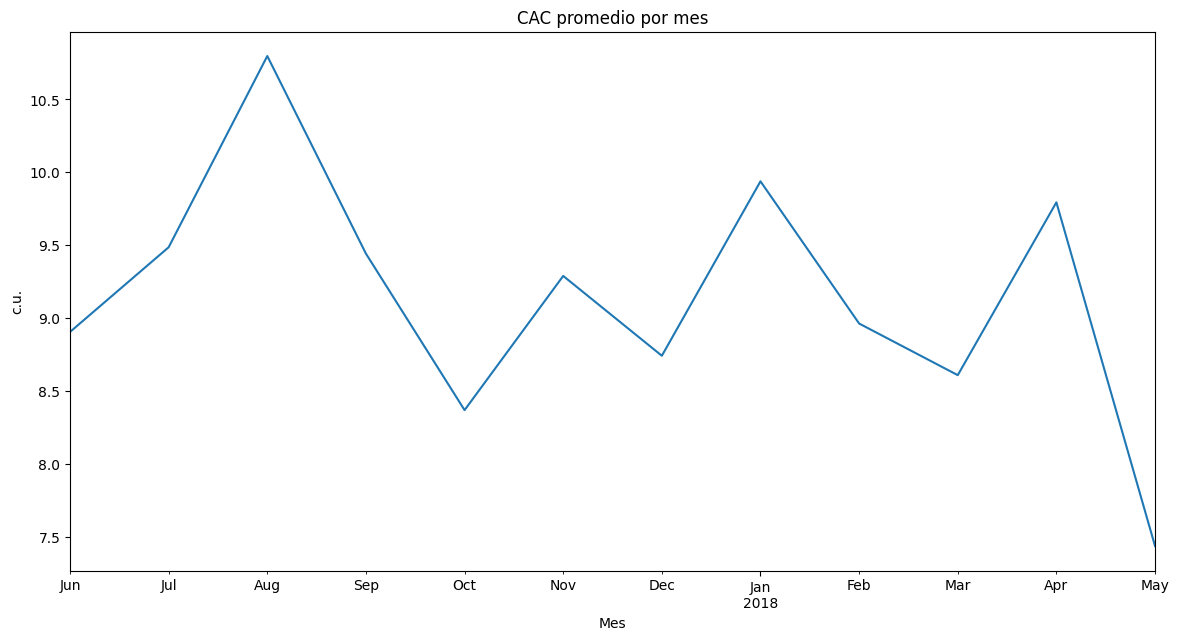

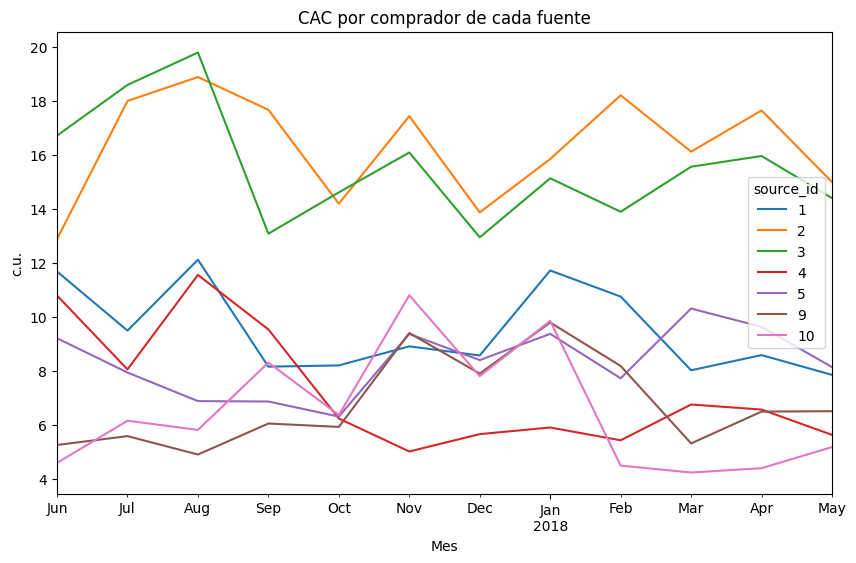

             cac
source_id       
1           9.49
2          16.29
3          15.58
4           7.27
5           8.34
9           6.84
10          6.56


In [60]:
# Calcular el CAC por mes
costs_df['dt'] = pd.to_datetime(costs_df['dt'])
costs_df['costs_month'] = costs_df['dt'].astype('datetime64[M]')
CAC_by_month = pd.merge(costs_df.groupby('costs_month').agg({'costs': 'sum'}),
                        buyers.groupby('first_order_month').agg({'uid': 'nunique'}),
                        left_index=True, right_index=True)
CAC_by_month['cac'] = CAC_by_month['costs'] / CAC_by_month['uid']

# Gráfico del CAC promedio por mes
CAC_by_month['cac'].plot(figsize=(14, 7), title='CAC promedio por mes', 
                         xlabel='Mes', ylabel='c.u.')

# Encontrar la primera fuente por visitante
users = visits_full.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]
buyers = pd.merge(buyers, users, left_on='uid', right_index=True)
buyers_daily = buyers.groupby(['source_id', 'first_order_day']).agg(
    {'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_day'] = pd.to_datetime(buyers_daily['first_order_day'])

# Calcular el CAC diario por fuente
costs_ = pd.merge(buyers_daily, costs_df, left_on=['source_id', 'first_order_day'], 
                  right_on=['source_id', 'dt'])
costs_['cac'] = costs_['costs'] / costs_['n_buyers']

# Gráfico de CAC diario por fuente y mes
costs_.pivot_table(index=['costs_month'], columns='source_id', 
                   values='cac', aggfunc='mean').plot(
    figsize=(10, 6), title='CAC por comprador de cada fuente', 
    xlabel='Mes', ylabel='c.u.')
plt.show()

# Calcular el CAC promedio por fuente
cac_by_source = costs_.groupby('source_id').agg({'cac': 'mean'}).round(2)
print(cac_by_source)


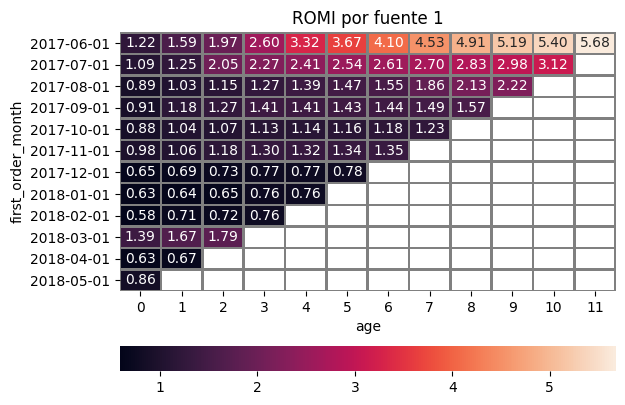

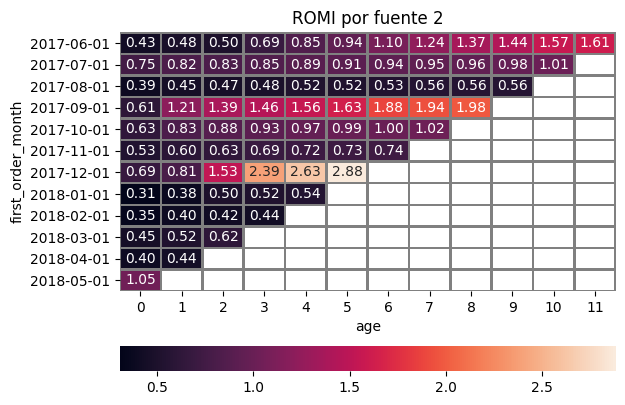

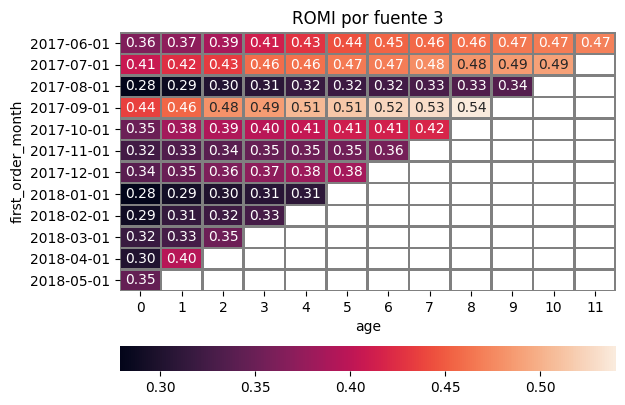

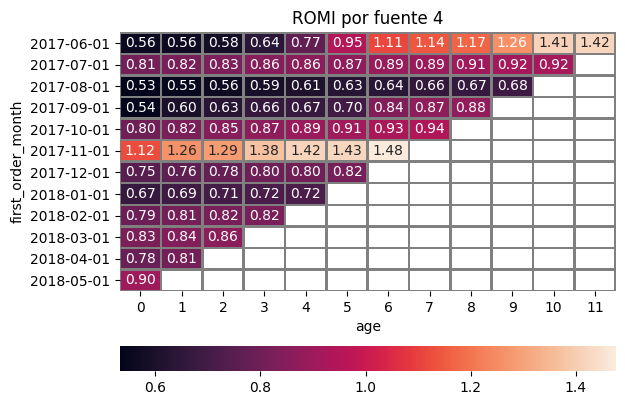

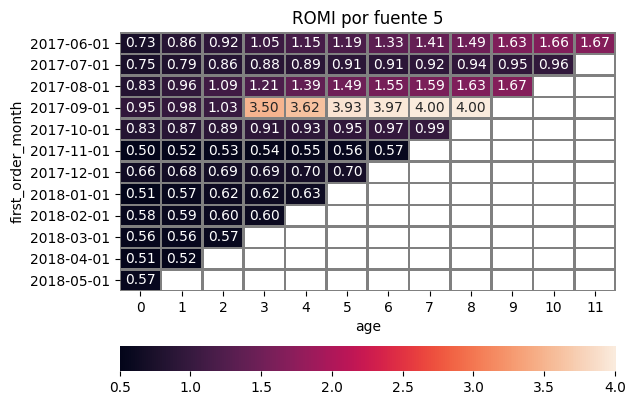

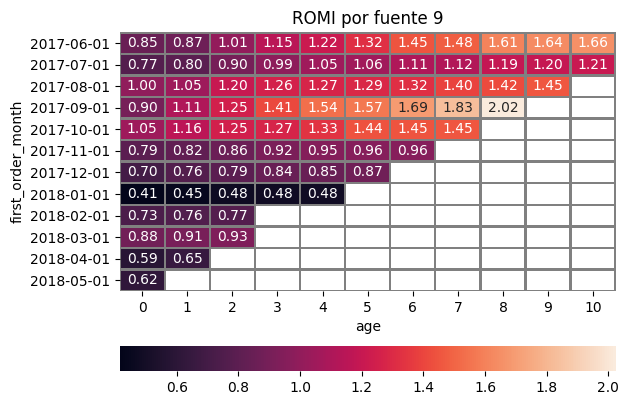

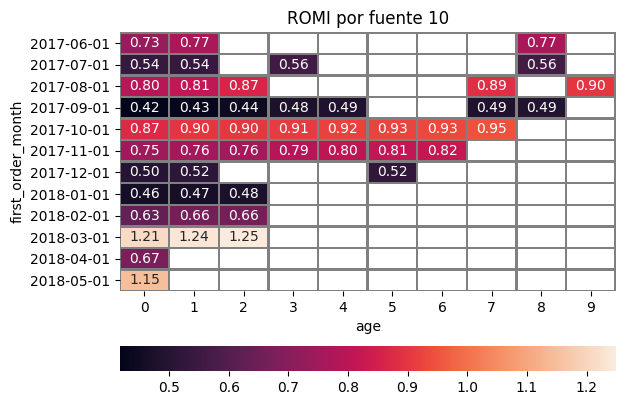

In [249]:
# ROMI
# Calcular ingresos mensuales por usuario
month_revenue = orders_df.groupby(['uid', 'order_month']).agg({'revenue': 'sum'}).reset_index()
buyers = buyers.merge(month_revenue, on='uid')

# Iterar a través de cada fuente de tráfico, excepto la fuente número 7
for source, df in buyers.groupby('source_id'):
    if source != 7:
        # Calcular el tamaño de la cohorte para cada fuente y mes de la primera orden
        cohort_sizes_t = (
            df.groupby(['source_id', 'first_order_month'])
            .agg({'uid': 'nunique'})
            .reset_index()
        )
        cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

        # Calcular los ingresos totales por cohorte
        cohorts_revenue_t = (
            df.groupby(['source_id', 'first_order_month', 'order_month'])
            .agg({'revenue': 'sum'})
            .reset_index()
        )
        cohorts_revenue_t.columns = ['source_id', 'first_order_month', 
                                     'order_month', 'gp']

        # Fusionar los tamaños de las cohortes con los ingresos por cohortes
        report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, 
                               on=['source_id', 'first_order_month'])
        report_romi['age'] = (
            report_romi['order_month'] - report_romi['first_order_month']
        ) / np.timedelta64(1, 'M')
        report_romi['age'] = report_romi['age'].round().astype('int')
        report_romi['ltv'] = report_romi['gp'] / report_romi['n_buyers']

        # Calcular costos y CAC para cada cohorte
        report_romi = pd.merge(report_romi, 
                               costs_df.groupby(['source_id', 
                                                 'costs_month']).agg(
                                   {'costs': 'sum'}).reset_index(),
                               left_on=['source_id', 'first_order_month'], 
                               right_on=['source_id', 'costs_month'])
        report_romi = report_romi.drop(['costs_month'], axis=1)
        report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
        report_romi['romi'] = report_romi['ltv'] / report_romi['cac']

        # Crear una tabla pivote de ROMI por edad para cada cohorte
        romi = report_romi\
                .pivot_table(index='first_order_month', columns='age', 
                             values='romi', aggfunc='mean')\
                .cumsum(axis=1)
        romi.round(2).fillna('')

        # Configurar el índice como cadena para un mejor formato
        romi.index = romi.index.astype(str)
        
        # Visualizar el ROMI utilizando un mapa de calor
        sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, 
                    linecolor='grey', cbar_kws={'orientation': 'horizontal'}
                    ).set(title='ROMI por fuente {}'.format(source))
        plt.show()

Análisis de rentabilidad de las fuentes de adquisición

De acuerdo con los resultados, las fuentes en las que conviene invertir son las siguientes:

* Fuente 1: presenta valores de ROMI muy altos en comparación a otras fuentes, se alcanzan retornos mayores a 1 o recuperación de la inversión desde los primeros meses, hay consistencia a nivel de cohortes y tienen un crecimiento sostenido. La cohorte 2017-06-01 es la que genera mayor rentabilidad.
* Fuente 9: tiene valores de ROMI medios, crecientes en el tiempo y estables a nivel de cohortes.  Las cohortes más rentables, las 5 primeras de 2017.
* Fuente 4: ROMI relativamente altos desde el inicio, con un crecimiento moderado y sostenido en el tiempo, estabilidad entre cohortes.

Para descartar:

Fuente 5: presenta un comportamiento irregular con picos elevados de ROMI en algunas cohortes y valores bajos con poco crecimiento en otras, especialmente en las más recientes, variable, poco predecible.
